In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

import math
from statistics import mean
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

from datetime import date
import datetime
import holidays

In [3]:
status = pd.read_csv('../../../status.csv')
trip = pd.read_csv('../../../trip.csv')
station = pd.read_csv('../../../station.csv')
weather = pd.read_csv('../../../weather.csv')

In [4]:
trip['start_date'] = pd.to_datetime(trip['start_date'], format='%d/%m/%Y %H:%M', infer_datetime_format=True)
trip['end_date'] = pd.to_datetime(trip['end_date'], format='%d/%m/%Y %H:%M', infer_datetime_format=True)
trip['start_hour'] = trip['start_date'].dt.hour
trip['end_hour'] = trip['end_date'].dt.hour
trip

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type,start_hour,end_hour
0,0,63,2013-08-29 14:13:00,54,2013-08-29 14:14:00,54,0,Subscriber,14,14
1,1,70,2013-08-29 14:42:00,8,2013-08-29 14:43:00,8,1,Subscriber,14,14
2,2,71,2013-08-29 10:16:00,20,2013-08-29 10:17:00,20,2,Subscriber,10,10
3,3,77,2013-08-29 11:29:00,8,2013-08-29 11:30:00,8,3,Subscriber,11,11
4,4,83,2013-08-29 12:02:00,54,2013-08-29 12:04:00,55,4,Subscriber,12,12
...,...,...,...,...,...,...,...,...,...,...
669954,669954,619,2014-09-01 04:21:00,41,2014-09-01 04:32:00,53,593,Subscriber,4,4
669955,669955,6712,2014-09-01 03:16:00,39,2014-09-01 05:08:00,58,51,Customer,3,5
669956,669956,538,2014-09-01 00:05:00,54,2014-09-01 00:14:00,45,248,Customer,0,0
669957,669957,568,2014-09-01 00:05:00,54,2014-09-01 00:15:00,45,236,Customer,0,0


In [5]:
StartMoveCount = np.zeros((70, 24))
len(StartMoveCount[0])

24

In [6]:
i = 0
while i < 70:
    j = 0
    while j < 24:
        trip_station = trip[trip['start_date'] < '2014-09-01']
        trip_station = trip_station[(trip_station['start_station_id']==i)]
        trip_station = trip_station[(trip_station['start_hour']==j)]
        StartMoveCount[i][j] = len(trip_station)
        j += 1
    i += 1
StartMoveCount

array([[ 34.,  53.,   1., ...,  85., 107.,  75.],
       [  3.,  13.,   3., ...,  22.,  25.,  11.],
       [ 17.,   9.,   5., ...,  12.,  21.,  26.],
       ...,
       [ 13.,   8.,   1., ...,  23.,  34.,  20.],
       [  2.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,   0.,   2., ...,   7.,   0.,   0.]])

In [7]:
EndMoveCount = np.zeros((70, 24))
i = 0
while i < 70:
    j = 0
    while j < 24:
        trip_station = trip[trip['end_date'] < '2014-09-01']
        trip_station = trip_station[(trip_station['end_station_id']==i)]
        trip_station = trip_station[(trip_station['end_hour']==j)]
        EndMoveCount[i][j] = len(trip_station)
        j += 1
    i += 1
EndMoveCount

array([[12.,  4.,  3., ..., 68., 62.,  8.],
       [15., 17.,  3., ..., 13., 11.,  5.],
       [29., 10.,  4., ..., 67., 76., 98.],
       ...,
       [14.,  2.,  6., ..., 44., 31., 15.],
       [ 3.,  1.,  0., ...,  6.,  9.,  4.],
       [ 1.,  5.,  3., ..., 15., 10.,  8.]])

In [8]:
Start_count = []
status_list = status.values.tolist()
for item in status_list:
    Start_count.append(int(StartMoveCount[int(item[5])][int(item[4])]))

In [9]:
End_count = []
for item in status_list:
    End_count.append(int(EndMoveCount[int(item[5])][int(item[4])]))

In [10]:
#statusにComeとOutを追加
status['StartCount_hour'] = Start_count
status['EndCount_hour'] = End_count
status.head()

,id,year,month,day,hour,station_id,bikes_available,predict,StartCount_hour,EndCount_hour
0,0,2013,9,1,0,0,11.0,0,34,12
1,1,2013,9,1,1,0,11.0,0,53,4
2,2,2013,9,1,2,0,11.0,0,1,3
3,3,2013,9,1,3,0,11.0,0,0,0
4,4,2013,9,1,4,0,11.0,0,1,10


In [11]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'])

#statusにstationのcityをマージ
status = pd.merge(status, station[['station_id', 'city']], how = 'left')

weather['date'] = pd.to_datetime(weather['date'])
#weatherのmean_wind_speedをマージ
status = pd.merge(status, weather[['date', 'mean_wind_speed']], how = 'left')

#weatherのprecipitationをマージ
status = pd.merge(status, weather[['date', 'precipitation']], how = 'left')

In [12]:
#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)
status.head(10)

,id,year,month,day,hour,station_id,bikes_available,predict,StartCount_hour,EndCount_hour,date,city,mean_wind_speed,precipitation,weekday
0,0,2013,9,1,0,0,11.0,0,34,12,2013-09-01,city1,4,0.0,日曜日
1,1,2013,9,1,1,0,11.0,0,53,4,2013-09-01,city1,4,0.0,日曜日
2,2,2013,9,1,2,0,11.0,0,1,3,2013-09-01,city1,4,0.0,日曜日
3,3,2013,9,1,3,0,11.0,0,0,0,2013-09-01,city1,4,0.0,日曜日
4,4,2013,9,1,4,0,11.0,0,1,10,2013-09-01,city1,4,0.0,日曜日
5,5,2013,9,1,5,0,11.0,0,2,216,2013-09-01,city1,4,0.0,日曜日
6,6,2013,9,1,6,0,11.0,0,113,273,2013-09-01,city1,4,0.0,日曜日
7,7,2013,9,1,7,0,11.0,0,526,545,2013-09-01,city1,4,0.0,日曜日
8,8,2013,9,1,8,0,11.0,0,854,197,2013-09-01,city1,4,0.0,日曜日
9,9,2013,9,1,9,0,11.0,0,373,122,2013-09-01,city1,4,0.0,日曜日


In [13]:
week_df = pd.get_dummies(status['weekday'])
#weatherのprecipitationをマージ
status['Saturday'] = week_df['土曜日']
status['Sunday'] = week_df['日曜日']
status['Monday'] = week_df['月曜日']
status['Tuesday'] = week_df['火曜日']
status['Wednesday'] = week_df['水曜日']
status['Thursday'] = week_df['木曜日']
status['Friday'] = week_df['金曜日']

In [14]:
#city列をcategorical encoderを用いて数値化
cols = ['city']

#encoder = ce.CountEncoder()
#temp_ = encoder.fit_transform(status[cols]).add_prefix("CE_")

# OneHotEncodeしたい列を指定
encoder = ce.OneHotEncoder(cols=cols, handle_unknown='impute')
temp_ = encoder.fit_transform(status[cols]).add_prefix("CE_")

status = pd.concat([status, temp_], axis=1)

In [15]:
#statusにstationのdock_countをマージ
status = pd.merge(status, station[['station_id', 'dock_count']], how = 'left')
#statusにstationのinstallation_dateをマージ
status = pd.merge(status, station[['station_id', 'installation_date']], how = 'left')

In [16]:
station_duration = np.zeros(70)
station_duration

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [17]:
i = 0
while i < 70:
    trip_station = trip[(trip['start_station_id']==i)]
    station_duration[i] = trip_station['duration'].median()
    i += 1

In [18]:
station_id_duration = []
for item in status_list:
    station_id_duration.append(station_duration[int(item[5])])

status['median_duration'] = station_id_duration

In [19]:
#statusのdate列の曜日を数値化
status['week_num'] = status['date'].dt.weekday
status.head()

,id,year,month,day,hour,station_id,bikes_available,predict,StartCount_hour,EndCount_hour,...,Friday,CE_city_1,CE_city_2,CE_city_3,CE_city_4,CE_city_5,dock_count,installation_date,median_duration,week_num
0,0,2013,9,1,0,0,11.0,0,34,12,...,0,1,0,0,0,0,27,8/6/2013,463.0,6
1,1,2013,9,1,1,0,11.0,0,53,4,...,0,1,0,0,0,0,27,8/6/2013,463.0,6
2,2,2013,9,1,2,0,11.0,0,1,3,...,0,1,0,0,0,0,27,8/6/2013,463.0,6
3,3,2013,9,1,3,0,11.0,0,0,0,...,0,1,0,0,0,0,27,8/6/2013,463.0,6
4,4,2013,9,1,4,0,11.0,0,1,10,...,0,1,0,0,0,0,27,8/6/2013,463.0,6


In [20]:
status_list = status.values.tolist()
day_list = []
for item in status_list:
    day_list.append([item[10], item[30]])

In [21]:
US_holiday_flag = []
for item in day_list:
    if(item[0] in holidays.US()):
        US_holiday_flag.append(1)
    elif(item[1] > 4):
        US_holiday_flag.append(1)
    else:
        US_holiday_flag.append(0)

In [22]:
CSULB_AC = {}
CSULB_AC[datetime.datetime(2013, 9, 2)] = 'Labor Day'
CSULB_AC[datetime.datetime(2013, 11, 11)] = 'Veterans Day'
i = 0
while i < 4:
    CSULB_AC[datetime.datetime(2013, 11, 27+i)] = 'Fall Break'
    i += 1
CSULB_AC[datetime.datetime(2013, 12, 1)] = 'Fall Break'
i = 0
while i < 7:
    CSULB_AC[datetime.datetime(2013, 12, 25+i)] = 'Winter Holiday'
    i += 1
    
CSULB_AC[datetime.datetime(2014, 1, 1)] = 'Winter Holiday'
CSULB_AC[datetime.datetime(2014, 1, 20)] = 'Martin Luther King Jr. Day'
i = 0
while i < 3:
    CSULB_AC[datetime.datetime(2014, 3, 29+i)] = 'Spring Recess'
    i += 1
i = 0
while i < 4:
    CSULB_AC[datetime.datetime(2014, 4, 1+i)] = 'Spring Recess'
    i += 1
i = 0
while i < 13:
    CSULB_AC[datetime.datetime(2014, 5, 19+i)] = 'Intersession'
    i += 1
i = 0
while i < 6:
    CSULB_AC[datetime.datetime(2014, 6, 1+i)] = 'Intersession'
    i += 1
CSULB_AC[datetime.datetime(2014, 7, 4)] = 'Independence Day'
CSULB_AC[datetime.datetime(2014, 9, 1)] = 'Labor Day'
CSULB_AC[datetime.datetime(2014, 11, 1)] = 'Veterans Da}y'
i = 0
while i < 5:
    CSULB_AC[datetime.datetime(2014, 11, 26+i)] = 'Fall Break'
    i += 1
i = 0
while i < 8:
    CSULB_AC[datetime.datetime(2014, 12, 24+i)] = 'Winter Holiday'
    i += 1
    
CSULB_AC[datetime.datetime(2015, 1, 1)] = 'Winter Holiday'
CSULB_AC[datetime.datetime(2015, 1, 19)] = 'Martin Luther King Jr. Day'
CSULB_AC[datetime.datetime(2015, 3, 30)] = 'Spring Recess'
CSULB_AC[datetime.datetime(2015, 3, 31)] = 'Spring Recess'
i = 0
while i < 5:
    CSULB_AC[datetime.datetime(2015, 12, 1+i)] = 'Spring Recess'
    i += 1
i = 0
while i < 14:
    CSULB_AC[datetime.datetime(2015, 5, 18+i)] = 'Intersession'
    i += 1
i = 0
while i < 5:
    CSULB_AC[datetime.datetime(2015, 6, 1+i)] = 'Intersession'
    i += 1
CSULB_AC[datetime.datetime(2015, 7, 3)] = 'Independence Day'


In [23]:
CSULB_AC_flag = []
for item in day_list:
    if(item[0] in CSULB_AC):
        CSULB_AC_flag.append(1)
    elif(item[1] > 4):
        CSULB_AC_flag.append(1)
    else:
        CSULB_AC_flag.append(0)

In [24]:
status['US_holiday_flag'] = US_holiday_flag
status['CSULB_AC_flag'] = CSULB_AC_flag

In [25]:
station_duration_hour = np.zeros((70, 24))
i = 0
while i < 70:
    j = 0
    while j < 24:
        trip_station = trip[(trip['start_station_id']==i)]
        trip_station = trip_station[(trip_station['start_hour']==j)]
        station_duration_hour[i][j] = trip_station['duration'].median()
        j += 1
    i += 1

In [26]:
status_duration = []
for item in status_list:
    status_duration.append(station_duration_hour[int(item[5])][int(item[4])])

status['median_duration_hour'] = status_duration

In [27]:
#同じステーション、同じ日において、0時時点の台数を特徴量に追加
#station_id, dateでグルーピングしたときの一番初めの値を取得
t = status.groupby(['station_id', 'date']).first()['bikes_available'].reset_index()
#24回リピートすることでデータのサイズを合わせる
t = pd.DataFrame(np.repeat(t.values, 24, axis=0))
t.columns = ['station_id', 'date', 'bikes_available_at0']
t.head(10)
status['bikes_available_at0'] = t['bikes_available_at0']

In [28]:
status['bikes_available_at0'] = status['bikes_available_at0'].astype(float)

In [29]:
#statusのdate列の曜日を数値化
trip['week_num'] = trip['start_date'].dt.weekday
trip

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,subscription_type,start_hour,end_hour,week_num
0,0,63,2013-08-29 14:13:00,54,2013-08-29 14:14:00,54,0,Subscriber,14,14,3
1,1,70,2013-08-29 14:42:00,8,2013-08-29 14:43:00,8,1,Subscriber,14,14,3
2,2,71,2013-08-29 10:16:00,20,2013-08-29 10:17:00,20,2,Subscriber,10,10,3
3,3,77,2013-08-29 11:29:00,8,2013-08-29 11:30:00,8,3,Subscriber,11,11,3
4,4,83,2013-08-29 12:02:00,54,2013-08-29 12:04:00,55,4,Subscriber,12,12,3
...,...,...,...,...,...,...,...,...,...,...,...
669954,669954,619,2014-09-01 04:21:00,41,2014-09-01 04:32:00,53,593,Subscriber,4,4,0
669955,669955,6712,2014-09-01 03:16:00,39,2014-09-01 05:08:00,58,51,Customer,3,5,0
669956,669956,538,2014-09-01 00:05:00,54,2014-09-01 00:14:00,45,248,Customer,0,0,0
669957,669957,568,2014-09-01 00:05:00,54,2014-09-01 00:15:00,45,236,Customer,0,0,0


In [30]:
station_duration_week = np.zeros((70, 7))
i = 0
while i < 70:
    j = 0
    while j < 7:
        trip_station = trip[trip['start_date'] < '2014-09-01']
        trip_station = trip[(trip['start_station_id']==i)]
        trip_station = trip_station[(trip_station['week_num']==j)]
        station_duration_week[i][j] = trip_station['duration'].median()
        j += 1
    i += 1
station_duration_week

array([[ 460.5,  453.5,  465. ,  452. ,  447. ,  586. ,  651. ],
       [ 464. ,  462. ,  515. ,  498.5,  575. , 1106.5, 1367. ],
       [ 268. ,  270. ,  265. ,  270. ,  289. ,  428. ,  465. ],
       [ 309. ,  342.5,  307. ,  318.5,  344. ,  511.5,  780. ],
       [ 389. ,  382. ,  388. ,  397.5,  426. ,  469.5,  627. ],
       [ 448.5,  439. ,  425. ,  447. ,  443. ,  514. ,  513. ],
       [ 359.5,  374. ,  354.5,  327. ,  404. ,  601.5,  668. ],
       [ 716. ,  727. ,  727. ,  728. ,  764. ,  802. ,  902. ],
       [ 484. ,  457.5,  461. ,  449.5,  479. ,  652. ,  800.5],
       [ 501. ,  500. ,  525.5,  510. ,  545. ,  744. ,  769. ],
       [ 360.5,  387. ,  364. ,  367.5,  436. ,  759. ,  758. ],
       [ 451. ,  444. ,  435. ,  441. ,  414.5,  452. ,  421. ],
       [ 413.5,  380. ,  261. ,  334. ,  413. ,  484. ,  584. ],
       [ 550. ,  542. ,  515. ,  510. ,  561. ,  624. ,  609. ],
       [ 271. ,  342. ,  240. ,  278. ,  255. ,  338.5, 2598. ],
       [ 302. ,  295. ,  

In [31]:
duration_week_count = []
for item in status_list:
    duration_week_count.append(station_duration_week[int(item[5])][int(item[30])])

status['median_duration_week'] = duration_week_count

In [32]:
StartCount_week = np.zeros((70, 7))
i = 0
while i < 70:
    j = 0
    while j < 7:
        trip_station = trip[trip['start_date'] < '2014-09-01']
        trip_station = trip[(trip['start_station_id']==i)]
        trip_station = trip_station[(trip_station['week_num']==j)]
        StartCount_week[i][j] = len(trip_station)
        j += 1
    i += 1
StartCount_week
StartCount_week_add = []
for item in status_list:
    StartCount_week_add.append(StartCount_week[int(item[5])][int(item[30])])

status['StartCount_week'] = StartCount_week_add

In [33]:
EndCount_week = np.zeros((70, 7))
i = 0
while i < 70:
    j = 0
    while j < 7:
        trip_station = trip[trip['end_date'] < '2014-09-01']
        trip_station = trip[(trip['end_station_id']==i)]
        trip_station = trip_station[(trip_station['week_num']==j)]
        EndCount_week[i][j] = len(trip_station)
        j += 1
    i += 1

EndCount_week_add = []
for item in status_list:
    EndCount_week_add.append(EndCount_week[int(item[5])][int(item[30])])

status['EndCount_week'] = EndCount_week_add

In [34]:
status.dtypes

id                               int64
year                             int64
month                            int64
day                              int64
hour                             int64
station_id                       int64
bikes_available                float64
predict                          int64
StartCount_hour                  int64
EndCount_hour                    int64
date                    datetime64[ns]
city                            object
mean_wind_speed                  int64
precipitation                  float64
weekday                         object
Saturday                         uint8
Sunday                           uint8
Monday                           uint8
Tuesday                          uint8
Wednesday                        uint8
Thursday                         uint8
Friday                           uint8
CE_city_1                        int64
CE_city_2                        int64
CE_city_3                        int64
CE_city_4                

In [36]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
train_week = status[status['date'] >= '2013-10-01']
train_week = train_week[train_week['date'] < '2013-11-01']
train_week = train_week[train_week['station_id'] == 0] 
train_week

,id,year,month,day,hour,station_id,bikes_available,predict,StartCount_hour,EndCount_hour,...,installation_date,median_duration,week_num,US_holiday_flag,CSULB_AC_flag,median_duration_hour,bikes_available_at0,median_duration_week,StartCount_week,EndCount_week
720,720,2013,10,1,0,0,16.0,0,34,12,...,8/6/2013,463.0,1,0,0,520.0,16.0,453.5,1886.0,1895.0
721,721,2013,10,1,1,0,14.0,0,53,4,...,8/6/2013,463.0,1,0,0,606.5,16.0,453.5,1886.0,1895.0
722,722,2013,10,1,2,0,14.0,0,1,3,...,8/6/2013,463.0,1,0,0,665.5,16.0,453.5,1886.0,1895.0
723,723,2013,10,1,3,0,14.0,0,0,0,...,8/6/2013,463.0,1,0,0,NaN,16.0,453.5,1886.0,1895.0
724,724,2013,10,1,4,0,14.0,0,1,10,...,8/6/2013,463.0,1,0,0,2740.0,16.0,453.5,1886.0,1895.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2013,10,31,19,0,19.0,0,470,110,...,8/6/2013,463.0,3,0,0,562.0,14.0,452.0,1906.0,1824.0
1460,1460,2013,10,31,20,0,18.0,0,111,73,...,8/6/2013,463.0,3,0,0,561.0,14.0,452.0,1906.0,1824.0
1461,1461,2013,10,31,21,0,18.0,0,85,68,...,8/6/2013,463.0,3,0,0,546.0,14.0,452.0,1906.0,1824.0
1462,1462,2013,10,31,22,0,18.0,0,107,62,...,8/6/2013,463.0,3,0,0,544.5,14.0,452.0,1906.0,1824.0


In [38]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
test_week = status[status['date'] >= '2013-11-01']
test_week = test_week[test_week['date'] < '2013-11-08']
test_week = test_week[test_week['station_id'] == 0] 
test_week

,id,year,month,day,hour,station_id,bikes_available,predict,StartCount_hour,EndCount_hour,...,installation_date,median_duration,week_num,US_holiday_flag,CSULB_AC_flag,median_duration_hour,bikes_available_at0,median_duration_week,StartCount_week,EndCount_week
1464,1464,2013,11,1,0,0,17.0,0,34,12,...,8/6/2013,463.0,4,0,0,520.0,17.0,447.0,1562.0,1513.0
1465,1465,2013,11,1,1,0,16.0,0,53,4,...,8/6/2013,463.0,4,0,0,606.5,17.0,447.0,1562.0,1513.0
1466,1466,2013,11,1,2,0,16.0,0,1,3,...,8/6/2013,463.0,4,0,0,665.5,17.0,447.0,1562.0,1513.0
1467,1467,2013,11,1,3,0,16.0,0,0,0,...,8/6/2013,463.0,4,0,0,NaN,17.0,447.0,1562.0,1513.0
1468,1468,2013,11,1,4,0,16.0,0,1,10,...,8/6/2013,463.0,4,0,0,2740.0,17.0,447.0,1562.0,1513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,1627,2013,11,7,19,0,18.0,0,470,110,...,8/6/2013,463.0,3,0,0,562.0,9.0,452.0,1906.0,1824.0
1628,1628,2013,11,7,20,0,16.0,0,111,73,...,8/6/2013,463.0,3,0,0,561.0,9.0,452.0,1906.0,1824.0
1629,1629,2013,11,7,21,0,16.0,0,85,68,...,8/6/2013,463.0,3,0,0,546.0,9.0,452.0,1906.0,1824.0
1630,1630,2013,11,7,22,0,16.0,0,107,62,...,8/6/2013,463.0,3,0,0,544.5,9.0,452.0,1906.0,1824.0


In [41]:
#使用カラムを限定
train_week = train_week[['hour', 'station_id',  'CE_city_1', 'CE_city_5', 'mean_wind_speed', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Thursday', 'Friday', 'Wednesday', 'StartCount_week', 'EndCount_week', 'bikes_available', 'median_duration_week', 'dock_count', 'US_holiday_flag', 'CSULB_AC_flag']]
test_week = test_week[['hour', 'station_id',  'CE_city_1', 'CE_city_5', 'mean_wind_speed', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Thursday', 'Friday', 'Wednesday', 'StartCount_week', 'EndCount_week', 'bikes_available', 'median_duration_week', 'dock_count', 'US_holiday_flag', 'CSULB_AC_flag']]

In [42]:
train_week_X = train_week.drop('bikes_available', axis = 1)
train_week_y = train_week['bikes_available']

In [43]:
test_week_X = test_week.drop('bikes_available', axis = 1)
test_week_y = test_week['bikes_available']

In [44]:
train_week_X.dtypes

hour                      int64
station_id                int64
CE_city_1                 int64
CE_city_5                 int64
mean_wind_speed           int64
Saturday                  uint8
Sunday                    uint8
Monday                    uint8
Tuesday                   uint8
Thursday                  uint8
Friday                    uint8
Wednesday                 uint8
StartCount_week         float64
EndCount_week           float64
median_duration_week    float64
dock_count                int64
US_holiday_flag           int64
CSULB_AC_flag             int64
dtype: object

In [45]:
import lightgbm as lgb

In [46]:
train_lightgbm_set = lgb.Dataset(train_week_X, train_week_y)
#valid_lightgbm_set = lgb.Dataset(valid_week_X, valid_week_y)

In [62]:
params = {
    "objective" : "regression",
    "metric" : "rmse",
#    "num_leaves": 200,
#    "learning_rate": 0.01,
#    "random_state" : 1,
    "verbose" : -1
}

In [64]:
model = lgb.train(
    params = params,
    train_set = train_lightgbm_set,
    valid_sets = [train_lightgbm_set, train_lightgbm_set],
    num_boost_round = 1000,
    early_stopping_rounds=10,
    verbose_eval=5
)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.78256
[10]	training's rmse: 2.52288
[15]	training's rmse: 2.33235
[20]	training's rmse: 2.22489
[25]	training's rmse: 2.14564
[30]	training's rmse: 2.08473
[35]	training's rmse: 2.02747
[40]	training's rmse: 1.94219
[45]	training's rmse: 1.90293
[50]	training's rmse: 1.87961
[55]	training's rmse: 1.85328
[60]	training's rmse: 1.8379
[65]	training's rmse: 1.82407
[70]	training's rmse: 1.81206
[75]	training's rmse: 1.80442
[80]	training's rmse: 1.79692
[85]	training's rmse: 1.7901
[90]	training's rmse: 1.78568
[95]	training's rmse: 1.78191
[100]	training's rmse: 1.77777
[105]	training's rmse: 1.77382
[110]	training's rmse: 1.77026
[115]	training's rmse: 1.76731
[120]	training's rmse: 1.76381
[125]	training's rmse: 1.76102
[130]	training's rmse: 1.75869
[135]	training's rmse: 1.75642
[140]	training's rmse: 1.75404
[145]	training's rmse: 1.75229
[150]	training's rmse: 1.75052
[155]	training's rmse: 1.74893


In [67]:
pred_lightgbn_train = model.predict(train_week_X)
print(pred_lightgbn_train)

[17.2457719  16.41812289 16.30886009 16.35543926 16.31962819 16.35858858
 17.2541704  17.46358291 15.89552828 12.02579148 11.37050664 10.62416212
 10.37315457 10.32829329 10.34825622 10.34008561 10.32248586 13.74175368
 17.46287584 16.64798081 15.53926174 15.67785393 15.85769384 15.35892071
 16.01582543 15.96279952 16.00615006 15.97649482 16.04161712 16.34017764
 17.0034729  17.29827194 13.4271965  10.1339882   7.61284683 11.44907192
 11.3986347  11.33250128 11.99218335 12.64720189 12.59865971 15.7814596
 17.98774492 17.37343215 16.81601876 17.48207015 18.11811211 18.19991981
 19.20240092 18.64073811 18.42732699 18.70293894 18.87407745 18.98029948
 19.26445286 19.58531375 16.43100923 12.81510746 12.07477008 10.67936637
 12.69513842 12.83857494 13.04205558 12.90200085 12.93981407 16.68465431
 18.08889279 17.34756944 16.47130963 15.17417769 15.39441509 14.90664793
 14.9418904  14.15080512 13.95785182 13.99599661 13.93853577 13.85139437
 14.25653933 14.84328116 12.88542704  7.04074307  6.

In [77]:
#validデータに対して予測
pred_lightgbm_test = model.predict(test_week_X)
pred_lightgbm_test

array([17.00930328, 16.78722805, 16.15916513, 15.97503024, 15.99659156,
       16.15269852, 17.73365503, 17.20592773, 15.80394697, 10.20777861,
        9.71878917,  9.43276562, 11.13978615, 11.66163857, 11.99957358,
       12.23060244, 11.81666092, 14.15797621, 15.68104178, 15.38897924,
       15.96079339, 18.21400662, 19.00598833, 19.52474216, 18.02426977,
       18.01966192, 17.98425543, 17.9876892 , 17.9718036 , 17.69376215,
       17.99303841, 17.64989467, 18.09142587, 17.83887934, 17.16104526,
       17.57590289, 17.43040252, 15.88082396, 15.73804968, 14.89341955,
       15.39585357, 15.05895609, 15.30104418, 15.69753002, 15.94068705,
       15.68340454, 15.73045084, 15.57151345, 13.14879246, 12.97626237,
       12.95296297, 12.9717564 , 13.00597462, 12.97788882, 12.99567962,
       13.09735313, 12.76622979, 13.19014659, 13.19545592, 15.76072953,
       16.30620417, 16.68983028, 17.24461568, 16.69315743, 17.05659969,
       17.20063051, 16.81680657, 17.10132701, 17.14306274, 16.31

In [70]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
train_visualization_lightgbm = status[status['date'] >= '2013-10-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['date'] < '2013-11-01']
train_visualization_lightgbm = train_visualization_lightgbm[train_visualization_lightgbm['station_id'] == 0] 

In [71]:
train_visualization_lightgbm['predict'] = pred_lightgbn_train

In [73]:
train_visualization_lightgbm['date_hour'] = train_visualization_lightgbm['year'].astype(str) + '/' + train_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + train_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
train_visualization_lightgbm['date_hour'] = pd.to_datetime(train_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)
train_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,StartCount_hour,EndCount_hour,...,median_duration,week_num,US_holiday_flag,CSULB_AC_flag,median_duration_hour,bikes_available_at0,median_duration_week,StartCount_week,EndCount_week,date_hour
720,720,2013,10,1,0,0,16.0,17.245772,34,12,...,463.0,1,0,0,520.0,16.0,453.5,1886.0,1895.0,2013-10-01 00:00:00
721,721,2013,10,1,1,0,14.0,16.418123,53,4,...,463.0,1,0,0,606.5,16.0,453.5,1886.0,1895.0,2013-10-01 01:00:00
722,722,2013,10,1,2,0,14.0,16.308860,1,3,...,463.0,1,0,0,665.5,16.0,453.5,1886.0,1895.0,2013-10-01 02:00:00
723,723,2013,10,1,3,0,14.0,16.355439,0,0,...,463.0,1,0,0,NaN,16.0,453.5,1886.0,1895.0,2013-10-01 03:00:00
724,724,2013,10,1,4,0,14.0,16.319628,1,10,...,463.0,1,0,0,2740.0,16.0,453.5,1886.0,1895.0,2013-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,1459,2013,10,31,19,0,19.0,19.015805,470,110,...,463.0,3,0,0,562.0,14.0,452.0,1906.0,1824.0,2013-10-31 19:00:00
1460,1460,2013,10,31,20,0,18.0,18.092472,111,73,...,463.0,3,0,0,561.0,14.0,452.0,1906.0,1824.0,2013-10-31 20:00:00
1461,1461,2013,10,31,21,0,18.0,18.013314,85,68,...,463.0,3,0,0,546.0,14.0,452.0,1906.0,1824.0,2013-10-31 21:00:00
1462,1462,2013,10,31,22,0,18.0,18.050874,107,62,...,463.0,3,0,0,544.5,14.0,452.0,1906.0,1824.0,2013-10-31 22:00:00


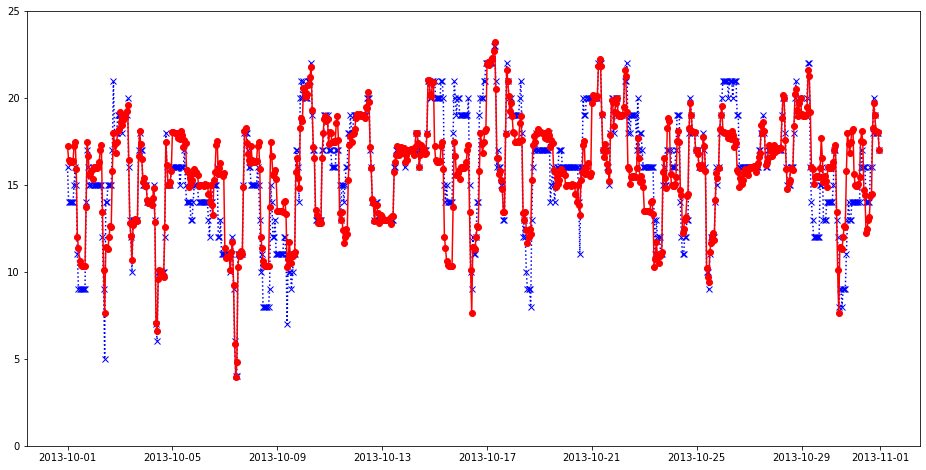

In [75]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(train_visualization_lightgbm['date_hour'], train_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [76]:
#2014/09/01以前をtrain、以後をtestに分割(testはpredict = 1のものに絞る)
test_visualization_lightgbm = status[status['date'] >= '2013-11-01']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['date'] < '2013-11-08']
test_visualization_lightgbm = test_visualization_lightgbm[test_visualization_lightgbm['station_id'] == 0] 

In [79]:
test_visualization_lightgbm['predict'] = pred_lightgbm_test

In [80]:
test_visualization_lightgbm['date_hour'] = test_visualization_lightgbm['year'].astype(str) + '/' + test_visualization_lightgbm['month'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['day'].astype(str).str.zfill(2).astype(str) + '/' + test_visualization_lightgbm['hour'].astype(str).str.zfill(2).astype(str)
test_visualization_lightgbm['date_hour'] = pd.to_datetime(test_visualization_lightgbm['date_hour'], format='%Y/%m/%d/%H', infer_datetime_format=True)
test_visualization_lightgbm

,id,year,month,day,hour,station_id,bikes_available,predict,StartCount_hour,EndCount_hour,...,median_duration,week_num,US_holiday_flag,CSULB_AC_flag,median_duration_hour,bikes_available_at0,median_duration_week,StartCount_week,EndCount_week,date_hour
1464,1464,2013,11,1,0,0,17.0,17.009303,34,12,...,463.0,4,0,0,520.0,17.0,447.0,1562.0,1513.0,2013-11-01 00:00:00
1465,1465,2013,11,1,1,0,16.0,16.787228,53,4,...,463.0,4,0,0,606.5,17.0,447.0,1562.0,1513.0,2013-11-01 01:00:00
1466,1466,2013,11,1,2,0,16.0,16.159165,1,3,...,463.0,4,0,0,665.5,17.0,447.0,1562.0,1513.0,2013-11-01 02:00:00
1467,1467,2013,11,1,3,0,16.0,15.975030,0,0,...,463.0,4,0,0,NaN,17.0,447.0,1562.0,1513.0,2013-11-01 03:00:00
1468,1468,2013,11,1,4,0,16.0,15.996592,1,10,...,463.0,4,0,0,2740.0,17.0,447.0,1562.0,1513.0,2013-11-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,1627,2013,11,7,19,0,18.0,19.015805,470,110,...,463.0,3,0,0,562.0,9.0,452.0,1906.0,1824.0,2013-11-07 19:00:00
1628,1628,2013,11,7,20,0,16.0,18.092472,111,73,...,463.0,3,0,0,561.0,9.0,452.0,1906.0,1824.0,2013-11-07 20:00:00
1629,1629,2013,11,7,21,0,16.0,18.013314,85,68,...,463.0,3,0,0,546.0,9.0,452.0,1906.0,1824.0,2013-11-07 21:00:00
1630,1630,2013,11,7,22,0,16.0,18.050874,107,62,...,463.0,3,0,0,544.5,9.0,452.0,1906.0,1824.0,2013-11-07 22:00:00


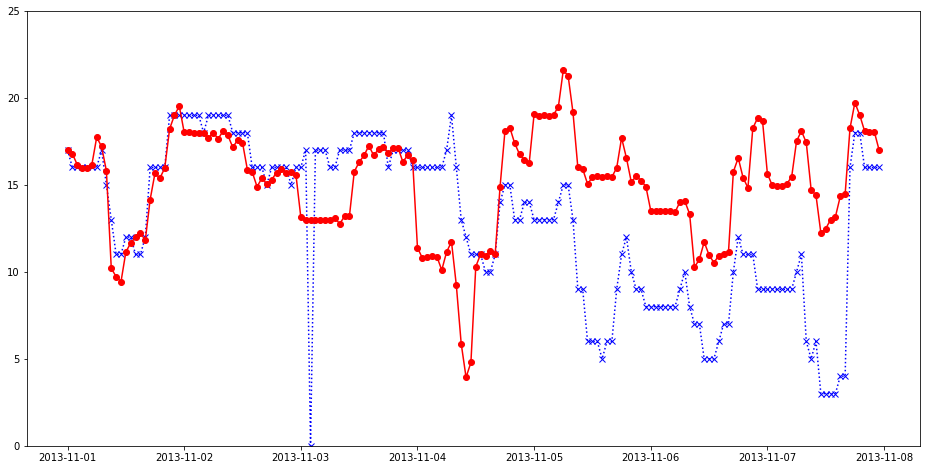

In [81]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['bikes_available'], color = 'blue', marker = 'x', linestyle = ':', label = 'predict')
plt.plot(test_visualization_lightgbm['date_hour'], test_visualization_lightgbm['predict'], color = 'red', marker = 'o', linestyle = '-', label = 'answer')

In [53]:
#trainをtrain, validに分割
train_basic_, valid_basic_ = train_test_split(train_week, test_size=0.3)
#説明変数と目的変数に分離
train_basic_X = train_basic_.drop('bikes_available', axis = 1)
train_basic_y = train_basic_['bikes_available']
valid_basic_X = valid_basic_.drop('bikes_available', axis = 1)
valid_basic_y = valid_basic_['bikes_available']

In [54]:
train_basic_set = lgb.Dataset(train_basic_X, train_basic_y)
valid_basic_set = lgb.Dataset(valid_basic_X, valid_basic_y)

In [60]:
params_v2 = {
    "objective" : "regression",
    "metric" : "rmse",
    "verbose" : -1
#    "num_leaves": 200,
#    "learning_rate": 0.01,
#    "random_state" : 1
}

In [66]:
model_basic = lgb.train(
    params = params_v2,
    train_set = train_basic_set,
    valid_sets = [train_basic_set, valid_basic_set],
    num_boost_round = 1000,
    early_stopping_rounds=10,
    verbose_eval=5
)

Training until validation scores don't improve for 10 rounds
[5]	training's rmse: 2.75421	valid_1's rmse: 3.08418
[10]	training's rmse: 2.51593	valid_1's rmse: 2.85346
[15]	training's rmse: 2.38746	valid_1's rmse: 2.73542
[20]	training's rmse: 2.29022	valid_1's rmse: 2.64634
[25]	training's rmse: 2.1847	valid_1's rmse: 2.54864
[30]	training's rmse: 2.10734	valid_1's rmse: 2.46931
[35]	training's rmse: 2.06205	valid_1's rmse: 2.43425
[40]	training's rmse: 2.02239	valid_1's rmse: 2.3952
[45]	training's rmse: 1.99519	valid_1's rmse: 2.37486
[50]	training's rmse: 1.96929	valid_1's rmse: 2.35456
[55]	training's rmse: 1.9281	valid_1's rmse: 2.31339
[60]	training's rmse: 1.90737	valid_1's rmse: 2.29595
[65]	training's rmse: 1.88725	valid_1's rmse: 2.27907
[70]	training's rmse: 1.86707	valid_1's rmse: 2.26535
[75]	training's rmse: 1.84499	valid_1's rmse: 2.2556
[80]	training's rmse: 1.82739	valid_1's rmse: 2.24114
[85]	training's rmse: 1.81224	valid_1's rmse: 2.23145
[90]	training's rmse: 1.80